In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [4]:
train_data = pd.read_csv("./archive/fashion-mnist_train.csv")
test_data = pd.read_csv("./archive/fashion-mnist_test.csv")

In [5]:
# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']

X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

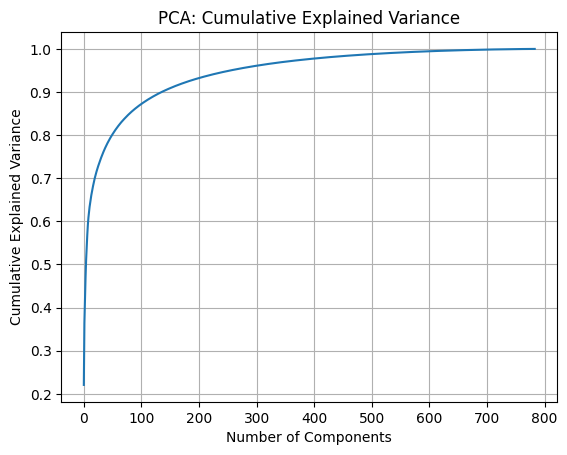

Optimal Number of Components: 256


In [6]:
# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_train)

# Fit PCA to the standardized data
pca = PCA()
pca.fit(X_train)

# Plot the cumulative explained variance
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Determine the optimal number of components
optimal_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1  # Choose a threshold (e.g., 95%)
print(f"Optimal Number of Components: {optimal_components}")

In [7]:
# Implement PCA
# You can choose the number of components based on your requirements
n_components = 256
pca = PCA(n_components=n_components)

In [8]:
# Define SVM classifier
svm_clf = SVC()

# Define an ensemble model with SVM as a backbone classifier
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
ensemble_clf = VotingClassifier(estimators=[('svm', svm_clf), ('rf', rf_clf)], voting='hard')

# Create a pipeline with PCA and SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('svm', svm_clf)
])

# Define parameter grids for SVM and Random Forest
svm_param_grid = {'svm__C': [0.1, 1, 10], 'svm__gamma': ['scale', 'auto'], 'svm__kernel': ['rbf', 'poly'], 'svm__degree': [2, 3, 4, 5]}
rf_param_grid = {'rf__n_estimators': [100], 'rf__max_depth': [None]}

# Perform GridSearchCV for SVM
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
svm_grid_search.fit(X_train, y_train)

# Perform GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Get the best models from the grid search
best_svm_clf = svm_grid_search.best_estimator_
best_rf_clf = rf_grid_search.best_estimator_

# Train the ensemble model with the best classifiers
ensemble_clf = VotingClassifier(estimators=[('svm', best_svm_clf), ('rf', best_rf_clf)], voting='hard', n_jobs=-1)
ensemble_clf.fit(X_train, y_train)

# Predictions on the test set
svm_predictions = best_svm_clf.predict(X_test)
ensemble_predictions = ensemble_clf.predict(X_test)

# Evaluate the models
svm_accuracy = accuracy_score(y_test, svm_predictions)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)

print(f"Best SVM Parameters: {svm_grid_search.best_params_}")
print(f"Best Random Forest Parameters: {rf_grid_search.best_params_}")
print(f"SVM Accuracy: {svm_accuracy}")
print(f"Ensemble Model Accuracy: {ensemble_accuracy}")

/usr/local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


ValueError: Invalid parameter 'rf' for estimator RandomForestClassifier(n_jobs=-1, random_state=42). Valid parameters are: ['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

In [11]:
best_svm_clf = svm_grid_search.best_estimator_
svm_predictions = best_svm_clf.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)

print(f"Best SVM Parameters: {svm_grid_search.best_params_}")
print(f"SVM Accuracy: {svm_accuracy}")

Best SVM Parameters: {'svm__C': 10, 'svm__degree': 3, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
SVM Accuracy: 0.9062
